outline
- overview of R packages
- installation using conda and yaml file
- intro to foreach
- advanced foreach features
- explanation of "back ends" difference between doMC, doSNOW, doParallel, doMPI
- reference sheet of parallel R packages
- doMC and slurm on cluster
- running on multiple nodes: doMPI and slurm
- scheduling (chunking)
- avoiding excess data copying
- a real example, with performance evaluation
 - kmeans with multiple starts (single foreach)
 - intro to nested foreach
 - kmeans with loop for k and multiple starts
 
- Rmpi
- n body?

## Parallel R Packages

- foreach: high level, parallel for loop method
- snow: original multihost, tcp/ssh method 
- multicore: original forking method
- parallel: unification of multicore and snow
- Rmpi: interface to MPI for advanced parallel programming

We will focus on __foreach__:
- easy to use
- most general

## Foreach
- designed and implemented by Steve Weston
- natural semantics, similar to _for_ loop
- [vignette](https://cran.r-project.org/web/packages/foreach/vignettes/foreach.pdf)
- similar to lapply
- works on multiple cpus on one machine, or on many machines

Foreach iterates over 1 or more indices, executes an expression on those indices, and returns a collection, by default a list:
```
foreach (arguments ...) %dopar% expr
```

In [ ]:
# setup for "forked" parallelism

library(foreach)
library(doMC)

registerDoMC(4)

In [ ]:
res <- foreach(i=1:10) %dopar% {
    i*i
}
res

In [ ]:
# simple function that simulates computing for set time
spin<-function(sec) {

  start<-proc.time()[[3]]

  while (TRUE) {
    z=1;
    for (i in 1:100000) {
      z<-z+1
    }
    now<-proc.time()[[3]]
    if (now-start > sec) { break }
  }
}

In [ ]:

f<-function(i){
    spin(i)
    i*i
}

system.time({
res<-foreach (i=1:8) %dopar% 
{
   f(i)
}
})

res

In [ ]:
# Rather than use a function, we can just put code in the block directly
res<-foreach (i=1:8) %dopar% 
{
    spin(i)
    i*i
}

res

## Combiners
Rather than returning the raw list, we can combine the values.  Foreach supports many combiners, using the named parameter .combine:
 - "c", "+", "*", "cbind", "rbind"
 - arbitrary user-supplied function of two variables

In [ ]:
# Here, we add all of the results into a single integer
res<-foreach (i=1:8, .combine="+") %dopar% 
{
    spin(i)
    i*i
}

res

In [ ]:
sum(1:8 * 1:8)

In [ ]:
mymax <- function(a,b) {
    if (a>b) a else b
}

In [ ]:
# User supplied combiner function.  
res<-foreach (i=1:8, .combine=mymax) %dopar% 
{
    spin(i)
    i*i
}

res

res<-foreach (i=1:8, .combine="mymax") %dopar% 
{
    spin(i)
    i*i
}

res

In [ ]:
# Be very careful not to forget the dot!
# Here, combine is an iteration variable with only 1 value
# So, we only use 1 value from i, and iterate once!

res<-foreach (i=1:10, combine="+") %dopar% 
{
    spin(i)
    i*i
}

res

## doMC Foreach batch script
```
#!/bin/bash
#SBATCH -c 4 

module load miniconda
source activate parallel_r
R --slave -f ex1.R
```

# Using multiple nodes
- Thus far, we've only used multiple cpus on a single node, via doMC
- Advantages (simple to use, no need to communicate)
- Limits the degree of parallelism (e.g. 28)
- Using the MPI "backend" allows us to scale to 100s or 1000s of cpus
- No change required to code body. We just create and register a different backend 
- Make sure to clean up at end:
```
closeCluster(cl)
mpi.quit()
```

## Changes to R code to use MPI backend
replace
```
library(doMC)
registerDoMC(cores)
```
with
```
library(doMPI)
startMPIcluster(verbose=TRUE, logdir="log")
registerDoMPI(cl)
...

closeCluster(cl)
mpi.quit()
```

## doMPI Foreach batch script
```
#!/bin/bash
#SBATCH -n 4

module load miniconda
source activate parallel_r
mpirun R --slave -f ex1mpi.R
```

## Notes on using multiple nodes
- It is possible to use other backends (doParallel or doSnow) to run on multiple nodes.  We recommend doMPI+slurm
- It is possible to specify the number of workers: ```startMPIcluster(count=3)``` but best to let slurm handle it
- The number of workers is slurm ntasks-1


## Kmeans
- classic method for clustering data.  You supply the number of clusters; the algorithm creates clusters that minimize total distance


In [ ]:
rides<-read.csv('Examples/Data/uber-raw-data-jun14.csv')
locs<-rides[,c('Lat','Lon')]
head(locs)
dim(locs)

In [ ]:
res<-kmeans(locs,5,10)


In [ ]:
res$centers

In [ ]:
library(plyr)

In [ ]:
ctrs<-as.data.frame(res$centers)
#ctrs<-rename(ctrs, c("Lon"="x", "Lat"="y"))
# get_googlemap really wants the df with lon, lat
ctrs<-ctrs[,c(2,1)]

In [ ]:
ctrs

In [ ]:
#install.packages('ggmap')

In [22]:
library(ggplot2)
library(ggmap)


# notes
to make the following work, I had to:
- eable maps static api and geocoding api on the google console for my project, and get an api key (below)
- 

In [23]:
register_google(API_KEY)

In [24]:
center<-geocode('grand central')

Source : https://maps.googleapis.com/maps/api/geocode/json?address=grand+central&key=xxx-q2rMRrjvk2Ty3zdMn61OaJaCGckMJEM


In [25]:
get_map(center)

Source : https://maps.googleapis.com/maps/api/staticmap?center=40.752726,-73.977229&zoom=10&size=640x640&scale=2&maptype=terrain&language=en-EN&key=xxx-q2rMRrjvk2Ty3zdMn61OaJaCGckMJEM


1280x1280 terrain map image from Google Maps. 
See ?ggmap to plot it.

In [ ]:
center

In [ ]:
p<-ggmap(get_googlemap(center=c(lon=-73.97723, lat=40.75273)))

In [ ]:
p

In [ ]:
center

In [ ]:
p<-ggmap(get_googlemap(center=c(lon=-73.97723, lat=40.75273)))

In [ ]:
?ggmap

In [ ]:
ctrs


Source : https://maps.googleapis.com/maps/api/staticmap?center=40.75273,-73.97723&zoom=10&size=640x640&scale=1&maptype=terrain&markers=40.687398,-73.966079%7C40.763296,-73.974748%7C40.728313,-74.005706%7C40.795478,-73.876404%7C40.664578,-73.7637&key=xxx-q2rMRrjvk2Ty3zdMn61OaJaCGckMJEM


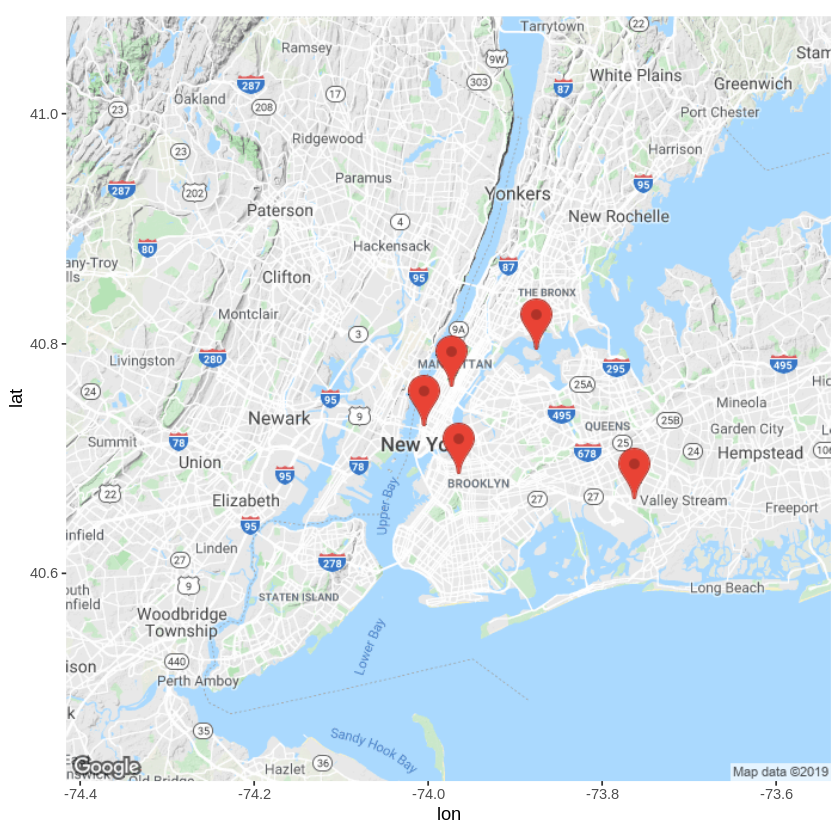

In [26]:
ggmap(get_googlemap(center=c(lon=-73.97723, lat=40.75273), markers = ctrs, zoom=10, scale = 1))
#ggmap(get_googlemap(center=c(lon=-73.97723, lat=40.75273), markers = ctrs, path = ctrs, zoom=10, scale = 1))


In [ ]:
df <- round(data.frame(
x = jitter(rep(-95.36, 50), amount = .3),
y = jitter(rep( 29.76, 50), amount = .3)
), digits = 2)
map <- get_googlemap('houston', markers = df, scale = 2)

In [ ]:
cores<-strtoi(Sys.getenv('SLURM_CPUS_PER_TASK', unset=1))
print(cores)
registerDoMC(cores)

starts=10
tasks=cores
nstarts=rep(starts/tasks, tasks)
clusters=seq(2,10)

print(c("tasks", tasks, "nstarts", nstarts, "clusters", clusters))

system.time({
results <-
  foreach (nstart=nstarts) %:%
    foreach (cluster=clusters) %dopar% {
  kmeans(locs, cluster, nstart=nstart)
}})

results <- unlist(results, recursive=FALSE)
i = sapply(results, function(result) result$tot.withinss)
result = results[[which.min(i)]]


In [ ]:
par_ctrs=as.data.frame(result$centers)[,c(2,1)]

In [ ]:
ggmap(get_googlemap(center=c(lon=-73.97723, lat=40.75273), markers = par_ctrs, zoom=10, scale = 1))

## Installing your own Parallel R environment on linux or macos
We recommend using conda

```
$ module load miniconda
$ conda create --name parallel_r -c conda-forge r-base r-essentials r-doMC r-Rmpi
```

This step must be done on login node
```
$ R
> install.packages('doMPI')
```
